## Package Import

In [524]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

## File Upload into Env

In [525]:
# Public URL after making the file public in the format 'https://storage.googleapis.com/...'
file_url = 'https://storage.googleapis.com/home_credit_files/application_train.csv'
test_url = 'https://storage.googleapis.com/home_credit_files/application_test.csv'
# POS_CASH_balance_url = 'https://storage.googleapis.com/home_credit_files/POS_CASH_balance.csv'
# bureau_url = 'https://storage.googleapis.com/home_credit_files/bureau.csv'
# bureau_balance_url = 'https://storage.googleapis.com/home_credit_files/bureau.csv'
# credit_card_balance = 'https://storage.googleapis.com/home_credit_files/credit_card_balance.csv'
# installments_payments = 'https://storage.googleapis.com/home_credit_files/credit_card_balance.csv'
# previous_application = 'https://storage.googleapis.com/home_credit_files/previous_application.csv'
sample_sub = 'https://storage.googleapis.com/home_credit_files/sample_submission.csv'


# Read the CSV directly from the URL
df = pd.read_csv(file_url)
test_df = pd.read_csv(test_url)

#print(df.head())

C:\Users\Owner\AppData\Local\Temp\ipykernel_23284\3497087744.py:14: DtypeWarning: Columns (90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_url)


## EDA

In [526]:
print(df.shape)

(307511, 122)


In [527]:
df['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [528]:
df['TARGET'].value_counts(normalize = True) * 100

TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64

### Evaluating Missingness

In [529]:
# Train data set

# calculate total number of missing values for each column
missing_values_train = df.isnull().sum()

# calculate total number of rows
total_rows_train = df.shape[0]

# calculate percentage of missing values for each column
pct_missing_train = (missing_values_train / total_rows_train) * 100

# sort output
pct_missing_sorted_train = pct_missing_train.sort_values(ascending=False)

In [530]:
missings = pct_missing_sorted_train.to_frame(name='MissingPercentage')

### Removing columns with greater than 10% missing values

In [531]:
filter_missings = missings[(missings['MissingPercentage'] < 10)]
filter_missings.shape

(65, 1)

### Removing 'FLAG' columns and ID column

In [532]:
columns = list(filter_missings.index)
column_list = [item for item in columns if 'FLAG' not in item]
#column_list_2 = [item for item in column_list if 'TARGET' not in item]
#column_list_3 = [item for item in column_list if 'SK_ID_CURR' not in item]

### Removing additional unhelpful columns

In [533]:
list1 = column_list
list2 = ['NAME_TYPE_SUITE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']

# Initialize an empty list to store items from list1 that are not in list2
items_not_in_list2 = []

# Iterate through each item in list1
for item in list1:
    # Check if the item is not in list2
    if item not in list2:
        # Add the item to the items_not_in_list2 list
        items_not_in_list2.append(item)

# Print the items that are not in list2
items_not_in_list2


['EXT_SOURCE_2',
 'AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'CNT_FAM_MEMBERS',
 'DAYS_LAST_PHONE_CHANGE',
 'CNT_CHILDREN',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'AMT_CREDIT',
 'AMT_INCOME_TOTAL',
 'LIVE_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'TARGET',
 'REG_CITY_NOT_LIVE_CITY',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_REGION_NOT_LIVE_REGION',
 'HOUR_APPR_PROCESS_START',
 'WEEKDAY_APPR_PROCESS_START',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'ORGANIZATION_TYPE',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'REGION_POPULATION_RELATIVE',
 'NAME_HOUSING_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_EDUCATION_TYPE',
 'NAME_INCOME_TYPE',
 'SK_ID_CURR']

In [534]:
len(items_not_in_list2)


32

In [535]:
pd.set_option('display.max_columns', None)
selected_df = df[items_not_in_list2]
selected_df

test_filtered_columns = [item for item in items_not_in_list2 if item != 'TARGET']
test_selected_df = test_df[test_filtered_columns]

In [536]:
# Extract the 'TARGET' column
target = selected_df['TARGET']

# Remove the 'TARGET' column from the dataframe and reassign the result back to selected_df
selected_df = selected_df.drop(columns=['TARGET'])

# Insert the 'TARGET' column at the beginning of the dataframe
selected_df.insert(0, 'TARGET', target)

### Fix problematic values

In [537]:
selected_df.loc[:, 'DAYS_EMPLOYED'] = selected_df['DAYS_EMPLOYED'].replace(365243, 0)
selected_df = selected_df[selected_df['AMT_INCOME_TOTAL'] <= 9000000]

test_selected_df.loc[:, 'DAYS_EMPLOYED'] = test_selected_df['DAYS_EMPLOYED'].replace(365243, 0)
test_selected_df = test_selected_df[test_selected_df['AMT_INCOME_TOTAL'] <= 9000000]

In [538]:
print(selected_df.shape)
print(test_selected_df.shape)

(307508, 32)
(48744, 31)


In [539]:
selected_df = selected_df.drop(columns = ['HOUR_APPR_PROCESS_START', 'DAYS_ID_PUBLISH'])
test_selected_df = test_selected_df.drop(columns = ['HOUR_APPR_PROCESS_START', 'DAYS_ID_PUBLISH'])

In [540]:
set(test_selected_df)-set(selected_df)

set()

In [541]:
# Abs value of negatives
selected_df['DAYS_LAST_PHONE_CHANGE'] = selected_df.loc[:, 'DAYS_LAST_PHONE_CHANGE'].abs()
selected_df['DAYS_REGISTRATION'] = selected_df.loc[:, 'DAYS_REGISTRATION'].abs()
selected_df['DAYS_EMPLOYED'] = selected_df.loc[:, 'DAYS_EMPLOYED'].abs()
selected_df['DAYS_BIRTH'] = selected_df.loc[:, 'DAYS_BIRTH'].abs()

test_selected_df['DAYS_LAST_PHONE_CHANGE'] = test_selected_df.loc[:, 'DAYS_LAST_PHONE_CHANGE'].abs()
test_selected_df['DAYS_REGISTRATION'] = test_selected_df.loc[:, 'DAYS_REGISTRATION'].abs()
test_selected_df['DAYS_EMPLOYED'] = test_selected_df.loc[:, 'DAYS_EMPLOYED'].abs()
test_selected_df['DAYS_BIRTH'] = test_selected_df.loc[:, 'DAYS_BIRTH'].abs()

## Preparing Logistic Regression

In [542]:
# Grab numeric columns
numeric_cols = selected_df.drop(['SK_ID_CURR'], axis=1).select_dtypes(include='number')
numeric_cols

test_numeric_cols = test_selected_df.drop(['SK_ID_CURR'], axis=1).select_dtypes(include='number')
test_numeric_cols

,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,AMT_CREDIT,AMT_INCOME_TOTAL,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,REG_REGION_NOT_LIVE_REGION,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE
0,0.789654,450000.0,20560.5,2.0,1740.0,0,568800.0,135000.0,0,0,0,0,0,0,2,2,5170.0,2329,19241,0.018850
1,0.291656,180000.0,17370.0,2.0,0.0,0,222768.0,99000.0,0,0,0,0,0,0,2,2,9118.0,4469,18064,0.035792
2,0.699787,630000.0,69777.0,2.0,856.0,0,663264.0,202500.0,0,0,0,0,0,0,2,2,2175.0,4458,20038,0.019101
3,0.509677,1575000.0,49018.5,4.0,1805.0,2,1575000.0,315000.0,0,0,0,0,0,0,2,2,2000.0,1866,13976,0.026392
4,0.425687,625500.0,32067.0,3.0,821.0,1,625500.0,180000.0,1,1,0,0,0,0,2,2,4000.0,2191,13040,0.010032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0.648575,270000.0,17473.5,1.0,684.0,0,412560.0,121500.0,0,0,0,0,0,0,3,3,9094.0,5169,19970,0.002042
48740,0.684596,495000.0,31909.5,4.0,0.0,2,622413.0,157500.0,1,1,0,0,0,0,2,2,3015.0,1149,11186,0.035792
48741,0.632770,315000.0,33205.5,3.0,838.0,1,315000.0,202500.0,0,0,0,0,0,0,2,2,2681.0,3037,15922,0.026392
48742,0.445701,450000.0,25128.0,2.0,2308.0,0,450000.0,225000.0,1,1,0,1,1,0,2,2,1461.0,2731,13968,0.018850


In [543]:
# Create a list of numeric column names excluding target for imputations

column_names = numeric_cols.columns.tolist()
my_list = [x for x in column_names if x != 'TARGET']
print(my_list)

test_column_names = numeric_cols.columns.tolist()
test_my_list = [x for x in column_names if x != 'TARGET']
print(test_my_list)

['EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE', 'CNT_CHILDREN', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'LIVE_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_LIVE_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_LIVE_REGION', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'REGION_POPULATION_RELATIVE']
['EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE', 'CNT_CHILDREN', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'LIVE_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_LIVE_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_LIVE_REGION', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'REGION_POPULATION_RELATIVE']


### N/a Imputer

In [544]:
# Create a SimpleImputer instance
imputer = SimpleImputer(strategy='median')

# Fit and transform the selected numeric columns
selected_df.loc[:, my_list] = imputer.fit_transform(selected_df.loc[:, my_list])

test_selected_df.loc[:, test_my_list] = imputer.fit_transform(test_selected_df.loc[:, test_my_list])

## Interaction Term

In [545]:
selected_df['CREDIT_TO_INCOME'] = selected_df['AMT_CREDIT']/selected_df['AMT_INCOME_TOTAL']

test_selected_df['CREDIT_TO_INCOME'] = test_selected_df['AMT_CREDIT']/test_selected_df['AMT_INCOME_TOTAL']

### Standard Scaler to scale dataset

In [227]:
#scalar_list = ['EXT_SOURCE_2','AMT_GOODS_PRICE','AMT_ANNUITY','AMT_CREDIT','AMT_INCOME_TOTAL','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT','CREDIT_TO_INCOME']

In [546]:
scaler = StandardScaler()

# Fit and transform the selected columns
selected_df[my_list] = scaler.fit_transform(selected_df[my_list])

test_selected_df[test_my_list] = scaler.fit_transform(test_selected_df[test_my_list])

print(selected_df.shape)
print(test_selected_df.shape)

(307508, 31)
(48744, 30)


### Dummy Encoder 

In [547]:
# dummy encoding data set

selected_df = pd.get_dummies(selected_df, drop_first=True)

test_selected_df = pd.get_dummies(test_selected_df, drop_first=True)

print(selected_df.shape)
print(test_selected_df.shape)

print(set(test_selected_df)-set(selected_df))
print(set(selected_df)-set(test_selected_df))

columns_to_drop = set(selected_df.columns) - set(test_selected_df.columns)
columns_to_drop.discard('TARGET')
selected_df = selected_df.drop(columns=list(columns_to_drop), axis=1)

print(selected_df.shape)
print(test_selected_df.shape)

(307508, 110)
(48744, 106)
set()
{'NAME_FAMILY_STATUS_Unknown', 'TARGET', 'CODE_GENDER_XNA', 'NAME_INCOME_TYPE_Maternity leave'}
(307508, 107)
(48744, 106)


### Splitting Target and Predictors

In [548]:
X = selected_df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = selected_df['TARGET']

## Logistic Regression 

In [549]:
# Initializing and training the logistic regression model
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X, y)

# Making predictions on the validation set
y_pred = log_reg.predict(X)

# Calculating the accuracy of the model
accuracy = accuracy_score(y, y_pred)
print("Train Accuracy:", accuracy)
print("Train R2 = ", log_reg.score(X, y))

Train Accuracy: 0.9192703929653863
Train R2 =  0.9192703929653863


## Cross Validation

### Mean Squared Error

In [232]:


# Call the function  and define a scoring function - set it as "neg_mean_squared_error"
log_scores = cross_val_score(log_reg, 
                             X, 
                             y,
                             scoring="neg_mean_squared_error",   # higher return values are better for this function
                             cv=10                               # create 10 folds
)

# to obtain RMSE, we need to negate the scores obtained  from cross_val_score and take the sqrt.
# this returns an array of 10 values
log_rmse_scores = np.sqrt(-log_scores)


In [233]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [234]:
display_scores(log_rmse_scores)

Scores: [0.28415725 0.28398553 0.28415725 0.28410002 0.28427167 0.28421446
 0.28410002 0.28415725 0.28410464 0.28410464]
Mean: 0.28413527334467237
Standard deviation: 7.287410277437027e-05


### R Squared

In [235]:
log_r2_scores = cross_val_score(log_reg, 
                             X, y,
                             scoring="r2", 
                             cv=10)
display_scores(log_r2_scores)

Scores: [-0.08823763 -0.08692281 -0.08823763 -0.08779936 -0.08871407 -0.08827595
 -0.08739972 -0.08783784 -0.08780246 -0.08780246]
Mean: -0.08790299290131771
Standard deviation: 0.0004764610029136554


In [550]:
log_auc_scores = cross_val_score(log_reg, 
                             X, 
                             y,
                             scoring="roc_auc", 
                             cv=10                               
)
log_mean_auc = np.mean(log_auc_scores)
display_scores(log_auc_scores)

Scores: [0.6903184  0.70347096 0.70158538 0.70195599 0.69615938 0.74887839
 0.70074192 0.67980056 0.69521011 0.69968139]
Mean: 0.7017802488408945
Standard deviation: 0.01707597037971625


## XGboost

In [551]:

xgb_clf = XGBClassifier(use_label_encoder=False, 
                        eval_metric='logloss', 
                        n_estimators=100, 
                        max_depth=4
                        )

xgb_clf.fit(X, y)

xgb_y_pred = xgb_clf.predict(X)

xgb_accuracy = accuracy_score(y, xgb_y_pred)

print("Train Accuracy:", xgb_accuracy)
print("Train Accuracy using built-in score:", xgb_clf.score(X, y))

Train Accuracy: 0.9194817695799784
Train Accuracy using built-in score: 0.9194817695799784


In [552]:
xgb_auc_scores = cross_val_score(xgb_clf, 
                             X, 
                             y,
                             scoring="roc_auc", 
                             cv=10                               
)
xgb_mean_auc = np.mean(xgb_auc_scores)
display_scores(xgb_auc_scores)

Scores: [0.70159317 0.71958385 0.71949374 0.71601226 0.71604402 0.75610023
 0.71818085 0.69783179 0.71091463 0.71473086]
Mean: 0.7170485401981802
Standard deviation: 0.014805251018788513


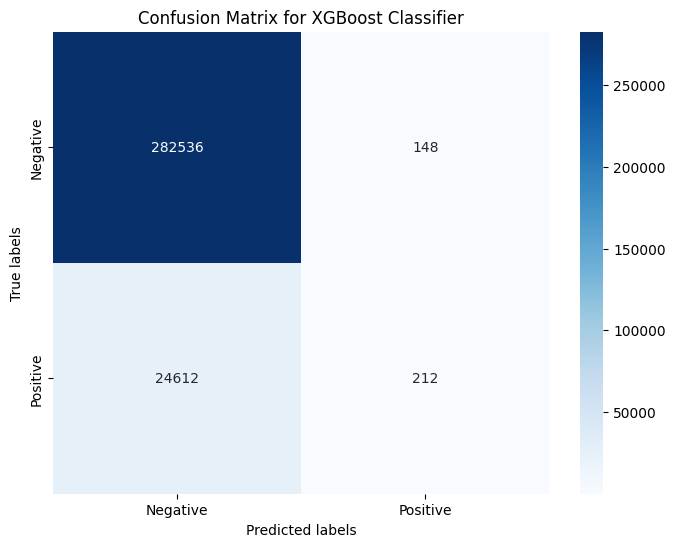

In [553]:
xgb_cm = confusion_matrix(y, xgb_y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()


## Random Forest

In [554]:
rf_clf = RandomForestClassifier(n_estimators=100, 
                                max_depth=3, 
                                random_state=42)

rf_clf.fit(X, y)

rf_y_pred = rf_clf.predict(X)

accuracy = accuracy_score(y, rf_y_pred)
print("Train Accuracy:", accuracy)
print("Train Accuracy using built-in score:", rf_clf.score(X, y))

Train Accuracy: 0.9192736449133031
Train Accuracy using built-in score: 0.9192736449133031


In [555]:
rf_auc_scores = cross_val_score(rf_clf, 
                             X, 
                             y,
                             scoring="roc_auc", 
                             cv=10                               
)
rf_mean_auc = np.mean(rf_auc_scores)
display_scores(rf_auc_scores)

Scores: [0.67240339 0.69188024 0.68495328 0.69081688 0.68175286 0.73026507
 0.68618528 0.66547121 0.67272217 0.68027047]
Mean: 0.6856720847124399
Standard deviation: 0.016884004092099194


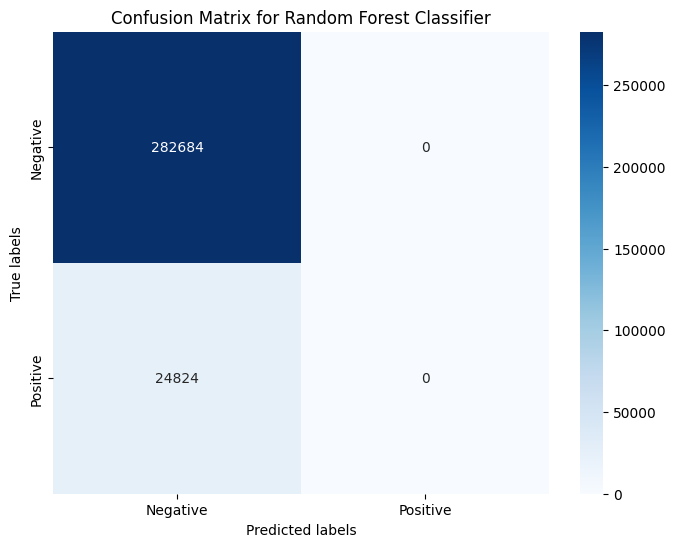

In [242]:
rf_cm = confusion_matrix(y, rf_y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

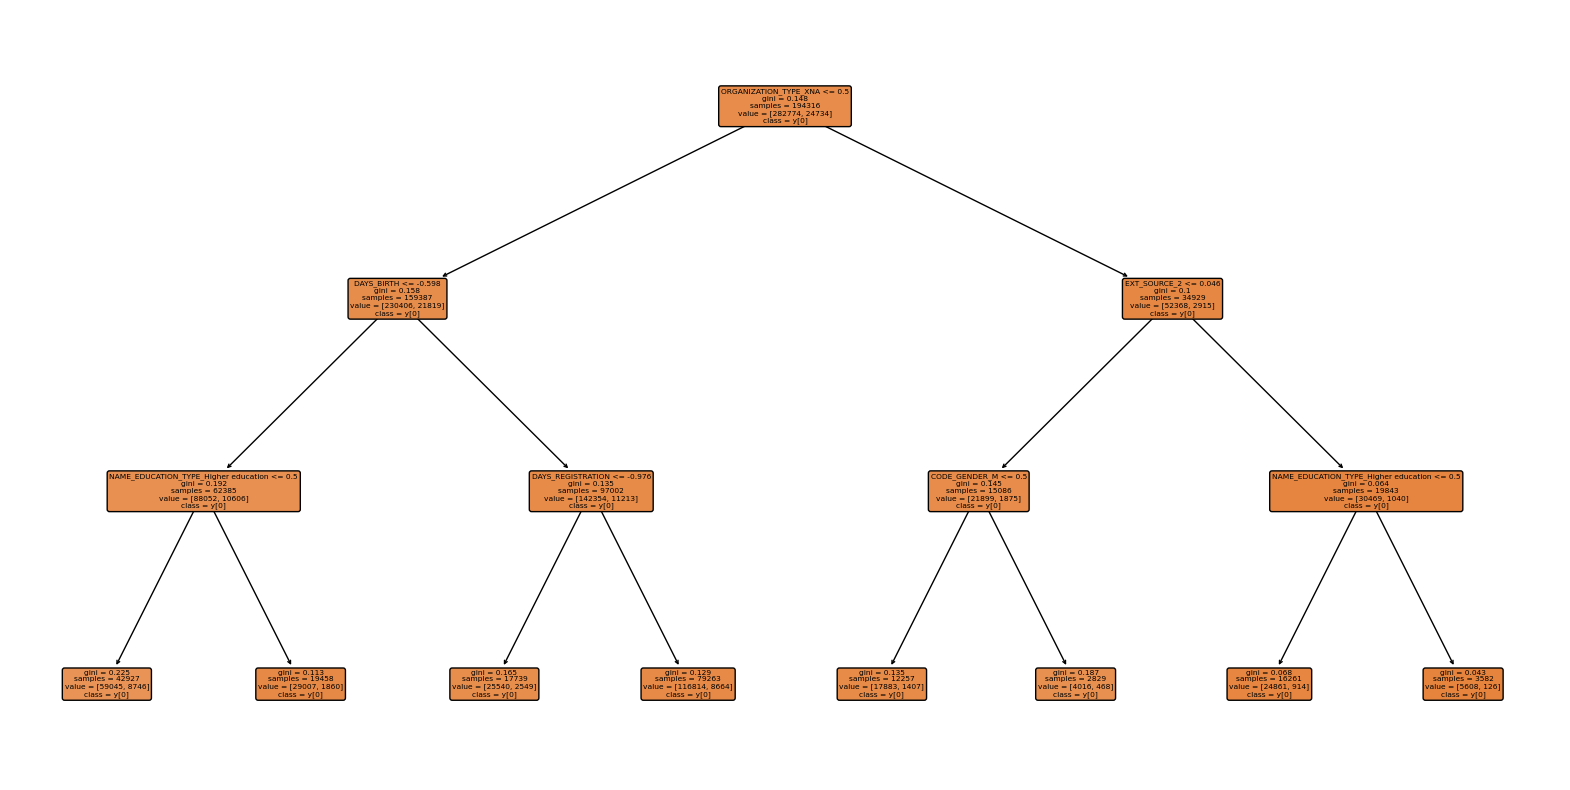

In [243]:
single_tree = rf_clf.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(single_tree, filled=True, feature_names=X.columns, class_names=True, rounded=True)
plt.show()